## Salinity, compare 202111 to 201905R

In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

from salishsea_tools import viz_tools

DFO data from 2013- Mar 2020  
PSF data from 2015- 2017  
PUG data from 2015- 2018  
ONC data from 2014- 2022
Ferry data from 2013- 2022

In [2]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [3]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [4]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

In [5]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [6]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [7]:
def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

In [8]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [19]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [10]:
def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

In [11]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [105]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    if 'ferry' in pieces[0]:
        temp1['SA'] = temp1['salinity (g/kg)']
        temp1['k'] = 0
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
        if 'ferry' in piece:
            temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

In [99]:
def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    if 'Z' in temp1.columns:
        temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
    else:
        temp1_nohook = temp1
# bad onc data
    if 'depth (m)' in temp1_nohook.columns:
        temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
    else:
        temp1_nobox_nohook = temp1_nohook
# bad ferry data
    temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
                                     & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    return temp1_clean

In [22]:
def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts


In [15]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [18]:
def plot_allyears(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False):
    if reverse:
        string = '_reverse'
    else:
        string = ''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    startyear = min(years[0], years_psf[0], years_pug[0])#, years_onc[0])
    endyear = max(years[-1], years_psf[-1], years_pug[-1])#, years_onc[-1])
    fig.suptitle(f'Year {startyear}-{endyear}')
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv')
    for year in years_psf:
        pieces1.append(
            f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    d201905, counts1 = plot_and_stats(filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0], whichdepths, reverse, string)
    
    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    d202111, counts2 = plot_and_stats(filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[1], whichdepths, reverse, string)

    alltogether = pd.concat([d201905, d202111], axis=0)
    
    fig.savefig(f'{whichdepths}_{field}{string}_201905_202111_for_allyears.png')
    
    f = open(f'./{whichdepths}_{field}{string}_201905_202111_for_allyears_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lcccccccccc', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    return alltogether, counts1, counts2

## All Depths

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,3630789,0.122,3.21,3.2,0.0767,0.0466,1.37,0.309,3.12,0.0785
202111,3630763,0.276,2.64,2.62,0.0528,0.0868,2.6,0.597,2.46,0.151


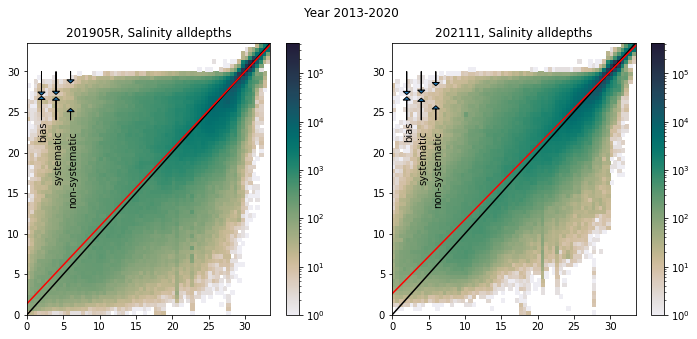

In [23]:
idepth = 0
jdepth = 39

results, counts1, counts2 = plot_allyears([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
                                          , [2015, 2016, 2017]
                                          , [2015, 2016, 2017, 2018]
                                       , [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')
results.style.format(myformat).apply(highlight_max_min)

## No Ferry ##

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1546285,0.0401,0.564,0.563,0.0401,-0.0714,-2.11,0.107,0.575,-0.136
202111,1546254,0.0176,0.5,0.5,0.0323,-0.0376,-1.12,0.055,0.507,-0.0716


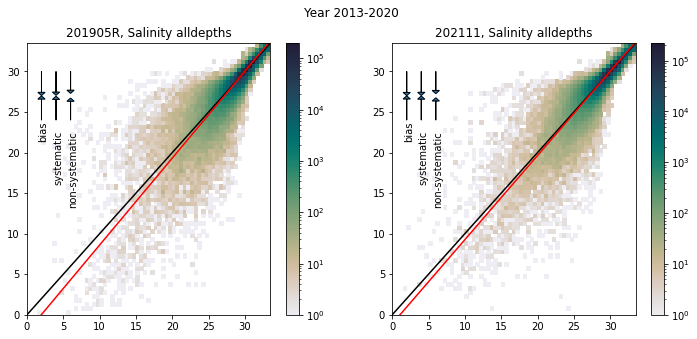

In [24]:
idepth = 0
jdepth = 39

results, counts1, counts2 = plot_allyears([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
                                          , [2015, 2016, 2017]
                                          , [2015, 2016, 2017, 2018]
                                       , [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []
                                          , idepth, jdepth, 'alldepths')
results.style.format(myformat).apply(highlight_max_min)

The new version 202111, is significantly better in RMSE than v201905, however, it is too salty near the surface.  One does not see this bias change if one excludes the ferry data.  Thus I think that the new bathymetry has improved the position of the plume but has enhanced the mixing of the plume.  Away from the Fraser River, the new rivers have generally improved the salinity.

## Top 5 m

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1541923,0.182,4.9,4.9,0.164,0.098,2.32,0.668,4.63,0.135
202111,1541883,0.602,4.03,3.98,0.11,0.116,3.12,0.97,3.7,0.179


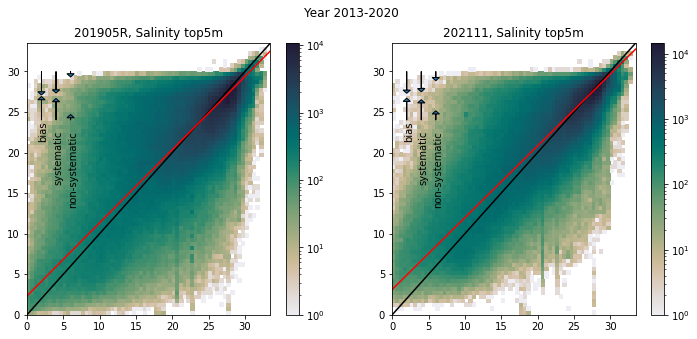

In [25]:
idepth = 0
jdepth = 5

results, counts1, counts2 = plot_allyears([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], 
                                          [2015, 2016, 2017, 2018], 
                                          [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], 
                                          [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                                          idepth, jdepth, 'top5m')
results.style.format(myformat).apply(highlight_max_min)

## Top 5 m: CTD Only

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,50414,-0.746,2.24,2.11,0.114,-0.182,-5.67,0.945,2.24,-0.316
202111,50369,-0.513,1.92,1.85,0.0854,-0.144,-4.39,0.688,1.94,-0.259


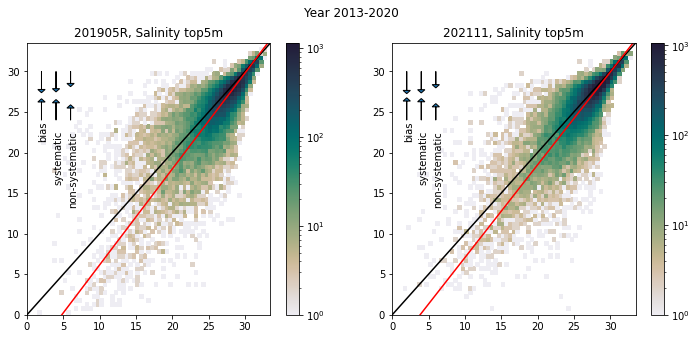

In [30]:
idepth = 0
jdepth = 5

results, counts1, counts2 = plot_allyears([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], 
                                          [2015, 2016, 2017], 
                                          [2015, 2016, 2017, 2018], 
                                          [],  
                                          [],
                                          idepth, jdepth, 'top5m', reverse=False)
results.style.format(myformat).apply(highlight_max_min)

## Below 5 m

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2088866,0.0772,0.371,0.363,0.0335,0.00965,0.371,0.0778,0.361,0.018
202111,2088880,0.0348,0.34,0.338,0.0286,0.0304,0.96,0.0469,0.331,0.0567


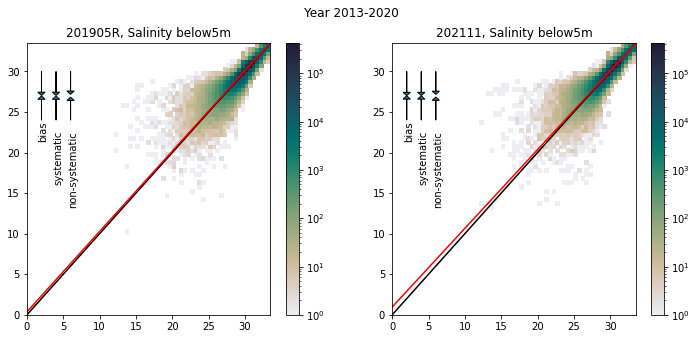

In [31]:
idepth = 5
jdepth = 39

results, counts1, counts2 = plot_allyears([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], 
                                          [2015, 2016, 2017], [2015, 2016, 2017, 2018], 
                                          [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], 
                                          [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                                          idepth, jdepth, 'below5m')
results.style.format(myformat).apply(highlight_max_min)

# Regionals

In [32]:
def stats_only(temp1, name, idepth, jdepth, corn, boxname):
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    number, tbias = bias(select, obsn, modn)
    if number > 0:
        trmse = rmse(select, obsn, modn)
        tcrmse = crmse(trmse, tbias)
        tswillmott = swillmott(select, obsn, modn)
        a1, b1, syst, nonsyst = wolfram_perp(select, obsn, modn)
        tspread = spread(select, obsn, modn)
        Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread,
          'region': boxname}
        dCp2 = pd.DataFrame(data=Cp2, index=[name])
    else:
        dCp2 = 0
    return number, dCp2

In [33]:
def stats_allregions(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths):
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')    
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')    
    temp1 = read_pieces(pieces1)
    
    number, alltogether = stats_only(filter_bad_data(temp1), '201905R', idepth, jdepth, boxes[0], boxnames[0])
    for boxname, corn in zip(boxnames[1:], boxes[1:]):
        number, d201905 = stats_only(filter_bad_data(temp1), '201905R', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d201905], axis=0)

    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
   
    for boxname, corn in zip(boxnames, boxes):
        number, d202111 = stats_only(filter_bad_data(temp2), '202111', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d202111], axis=0)
    f = open(f'./{whichdepths}_{field}_201905_202111_for_allregions_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccccl', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, None]))
    f.close()
    return alltogether

In [97]:
def stats_and_plot(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, box, boxname, whichdepths):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
#    fig.suptitle(f'{boxname} Year {years[0]}-{years[-1]}')
    
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')   
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   
    temp1 = read_pieces(pieces1)
    
    alltogether, counts = plot_and_stats(filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0], whichdepths, False, '', boxes=True, box=box, boxname=boxname)

    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    print (temp2)
    print (temp2['k'])
    d202111, counts = plot_and_stats(filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[1], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    
    plot_profiles(temp1, temp2, axs[2], axs[3], box, boxname)
    
    
    alltogether = pd.concat([alltogether, d202111], axis=0)

    return temp1, temp2

In [191]:
def plot_profiles(temp1, temp2, ax, ax2, box, boxname):

    corn = box
    temp1['diff'] = temp1[modn] - temp1[obsn]
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3]) &
                              (temp1[modn] < 1000)]
    kls = len(select.groupby('k')[obsn])
    ax.plot(select.groupby('k')[obsn].mean(), deptht[:kls], 'o-', c='tab:green', label='Observations')
    ax.plot(select.groupby('k')[modn].mean(), deptht[:kls], 'o-', c='tab:blue', label='201905')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[:kls], '-', c='tab:blue', label='201905')
    ax.fill_betweenx(deptht[:kls], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:blue')
    ax2.fill_betweenx(deptht[:kls], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:blue')
    
    temp2['diff'] = temp2[modn] - temp2[obsn]
    select = temp2[(temp2.k >= idepth) & (temp2.k <= jdepth) &
                              (temp2.j >= corn[0]) & (temp2.j <= corn[1]) &
                              (temp2.i >= corn[2]) & (temp2.i <= corn[3])]
    
    ax.plot(select.groupby('k')[modn].mean(), deptht[:kls], 'o-', c='tab:orange', label='202111')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[:kls], '-', c='tab:orange', label='202111')
    ax.fill_betweenx(deptht[:kls], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:orange')
    ax.fill_betweenx(deptht[:kls], select[['k', obsn]].groupby('k').quantile(q=0.25)[obsn], select[['k', obsn]].groupby('k').quantile(q=0.75)[obsn], alpha=0.2, color='tab:orange')
    ax2.fill_betweenx(deptht[:kls], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:orange')
    
    ax.invert_yaxis()
    ax2.invert_yaxis()
    
    ax.legend()
    ax2.legend()
    ax.set_title(f'{field} Profiles')
    ax2.set_title(f'{field} Difference Profiles')
    ax2.grid();

In [112]:
def plot_map(temp1, temp2, ax, box, boxname, idepth, jdepth):
    corn = box
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    kls = len(select.groupby('k')[obsn])
    ax.plot(select.Lon[select[obsn] < 15], select.Lat[select[obsn]< 15], 'o', c='tab:blue')
    ax.plot(select.Lon[select[obsn] > 15], select.Lat[select[obsn]> 15], 'o', c='tab:green')
    ax.plot(select.Lon[select[obsn] > 20], select.Lat[select[obsn]> 20], 'o', c='tab:orange')
    ax.plot(select.Lon[select[obsn] > 25], select.Lat[select[obsn]> 25], 'o', c='tab:red')

    print (select[obsn][select.Lon < -123.4].mean())
    print (select[modn][select.Lon < -123.4].mean())

In [36]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

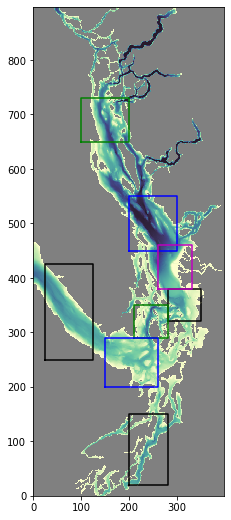

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'g')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'b')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'k')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'k')
SS_all = [0, 898, 0, 398]
boxes = [SS_all, SoG_south,SoG_center, SoG_north, PS_main, Haro_Boundary, JdF_west, JdF_east]
boxnames = ['SS_all', 'SoG_south', 'SoG_center', 'SoG_north', 'PS_main', 'Haro_Boundary',
           'JdF_west', 'JdF_east']
Fraser_plume = [380, 460, 260, 330]
plot_box(ax, Fraser_plume, 'm')

## All Depths

In [39]:
idepth = 0
jdepth = 39

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
                                          , [2015, 2016, 2017]
                                          , [2015, 2016, 2017, 2018]
                                       , [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                           idepth, jdepth, 'alldepths')
for boxname in boxnames:
    if results[results.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results[results.region == boxname].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

SS_all


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,3630789,0.122,3.21,3.2,0.0767,0.0466,1.37,0.309,3.12,0.0785
202111,3630763,0.276,2.64,2.62,0.0528,0.0868,2.6,0.597,2.46,0.151


SoG_south


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,46741,0.0931,0.532,0.524,0.0571,0.00075,0.116,0.0931,0.524,0.00134
202111,46741,0.065,0.517,0.513,0.0566,0.0563,1.76,0.0915,0.495,0.0986


SoG_center


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1053257,-0.405,3.07,3.05,0.118,-0.0209,-0.958,0.417,3.08,-0.0332
202111,1053262,-0.221,2.67,2.66,0.0856,-0.0378,-1.22,0.282,2.7,-0.0644


SoG_north


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,220535,0.184,0.447,0.407,0.0449,-0.0354,-0.865,0.188,0.413,-0.0666
202111,220542,0.153,0.401,0.371,0.039,0.0471,1.55,0.161,0.359,0.0864


PS_main


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,48823,0.105,0.541,0.531,0.134,-0.00371,-0.00568,0.105,0.532,-0.00567
202111,48823,0.155,0.533,0.51,0.104,-0.248,-7.23,0.246,0.543,-0.449


Haro_Boundary


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,42420,-0.0647,0.375,0.369,0.0471,-0.0659,-2.13,0.0857,0.377,-0.124
202111,42420,-0.0891,0.348,0.336,0.0406,-0.057,-1.88,0.102,0.343,-0.108


JdF_west


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,25283,-0.0871,0.413,0.403,0.0366,-0.0153,-0.59,0.0886,0.406,-0.0288
202111,25283,-0.0898,0.391,0.38,0.0326,-0.0207,-0.769,0.0926,0.384,-0.0393


JdF_east


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,65417,-0.0874,0.405,0.396,0.0516,-0.00192,-0.149,0.0875,0.396,-0.00348
202111,65417,-0.109,0.373,0.357,0.0424,-0.0253,-0.914,0.111,0.36,-0.0474


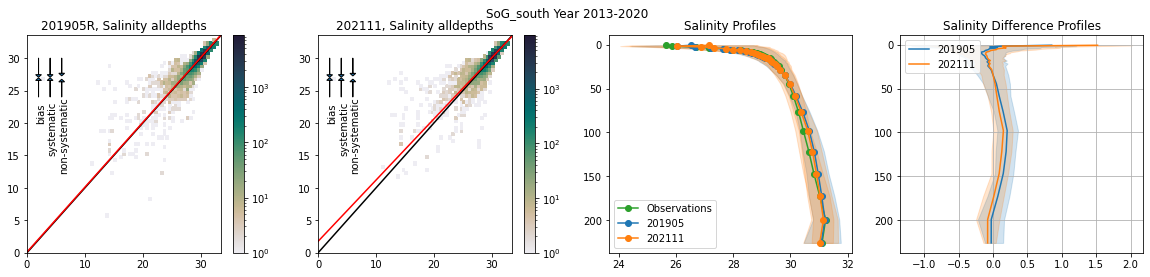

In [40]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], 
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, SoG_south, 'SoG_south', 'alldepths')

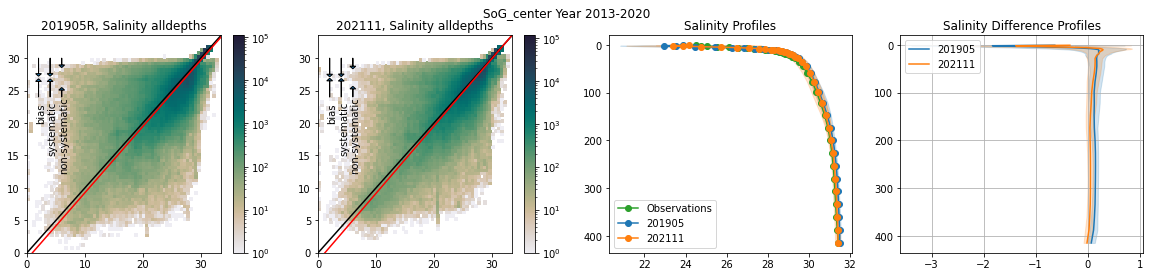

In [41]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], 
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, SoG_center, 'SoG_center', 'alldepths')

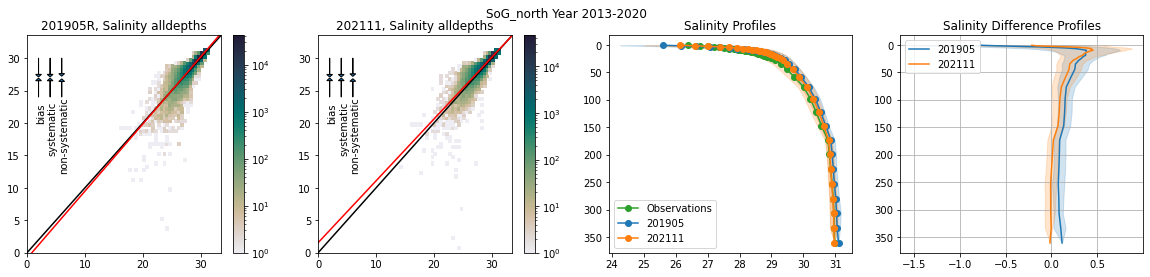

In [42]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, SoG_north, 'SoG_north', 'alldepths')

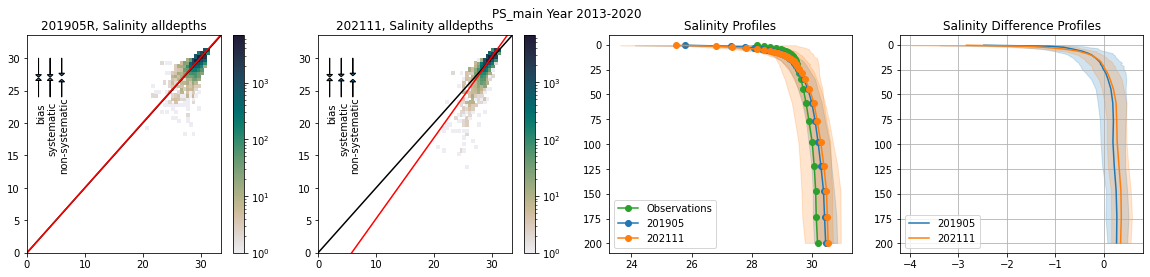

In [43]:
idepth = 0
jdepth = 39
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, PS_main, 'PS_main', 'alldepths')

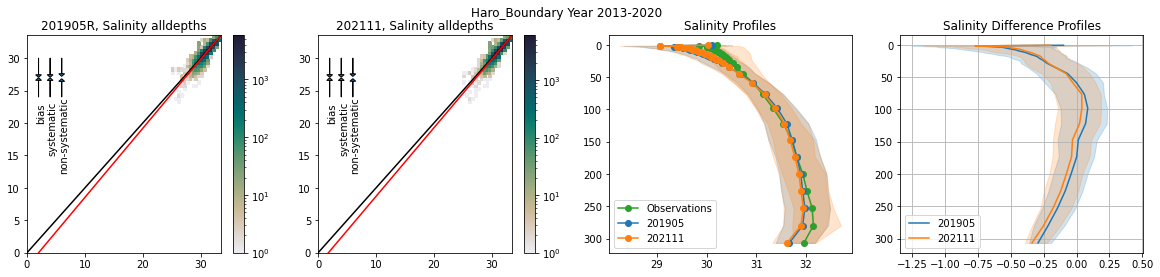

In [44]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, Haro_Boundary, 'Haro_Boundary', 'alldepths')

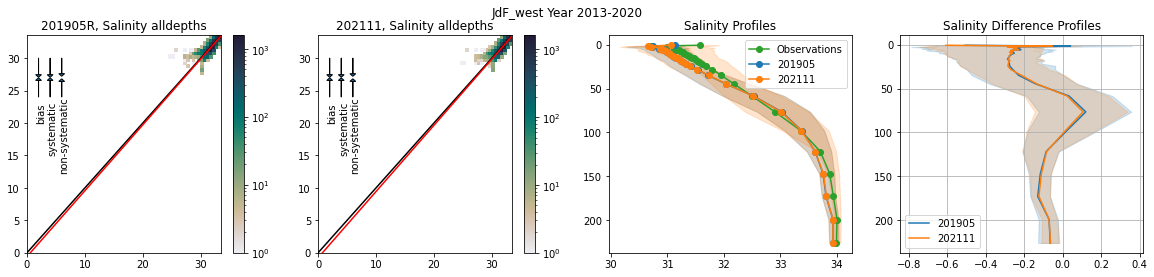

In [45]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, JdF_west, 'JdF_west', 'alldepths')

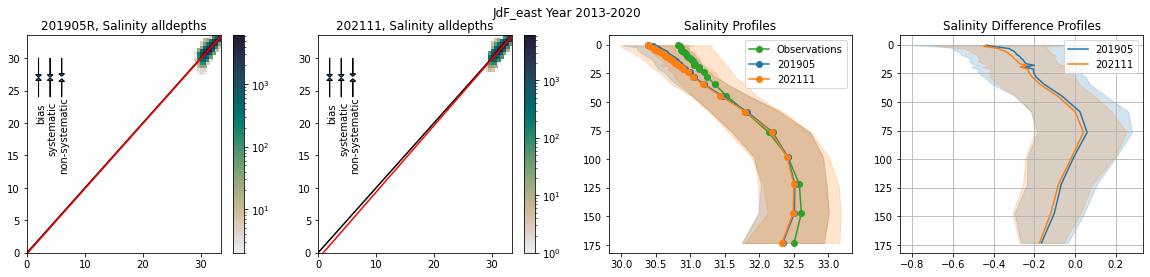

In [46]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, JdF_east, 'JdF_east', 'alldepths')

         Unnamed: 0    Year  Month   Day       Hour        Lat        Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.08100   
1                 1  2013.0    1.0  10.0  17.118056  49.329667 -124.08100   
2                 2  2013.0    1.0  10.0  17.118056  49.329667 -124.08100   
3                 3  2013.0    1.0  10.0  17.118056  49.329667 -124.08100   
4                 4  2013.0    1.0  10.0  17.118056  49.329667 -124.08100   
...             ...     ...    ...   ...        ...        ...        ...   
1586222       54755     NaN    NaN   NaN        NaN  47.213427 -123.07765   
1586223       54756     NaN    NaN   NaN        NaN  47.213427 -123.07765   
1586224       54757     NaN    NaN   NaN        NaN  47.213427 -123.07765   
1586225       54758     NaN    NaN   NaN        NaN  47.213427 -123.07765   
1586226       54759     NaN    NaN   NaN        NaN  47.213427 -123.07765   

                 Z         SA        CT  ...  chl  o2SAT  o2uM conductivity

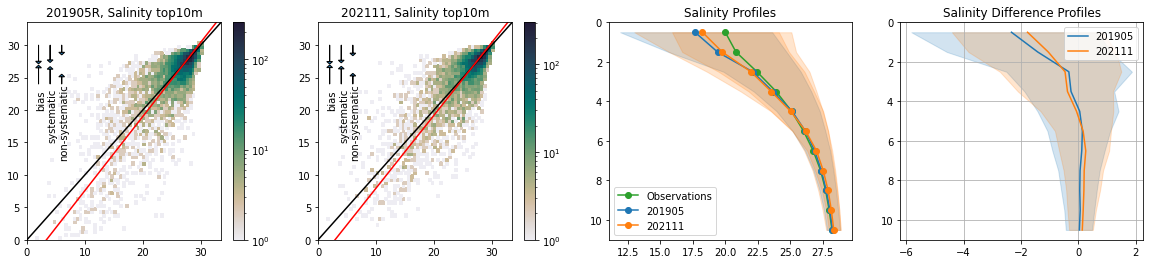

In [194]:
idepth = 0
jdepth = 10
temp1, temp2 = stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017], 
               [2015, 2016, 2017, 2018], 
             #  [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], 
               [], [],
               idepth, jdepth, Fraser_plume, 'Fraser_plume', 'top10m')

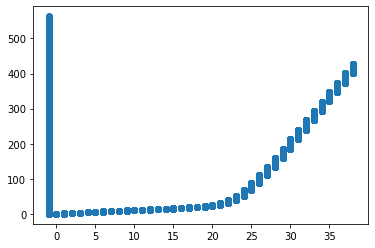

In [196]:
plt.plot(temp1.k, temp1.Z, 'o')

         Unnamed: 0    Year  Month   Day       Hour        Lat         Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
1                 1  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
2                 2  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
3                 3  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
4                 4  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
...             ...     ...    ...   ...        ...        ...         ...   
3690046      111634     NaN    NaN   NaN        NaN  48.996181 -123.141334   
3690047      111635     NaN    NaN   NaN        NaN  48.998321 -123.136821   
3690048      111636     NaN    NaN   NaN        NaN  48.999988 -123.133275   
3690049      111637     NaN    NaN   NaN        NaN  49.001393 -123.131266   
3690050      111638     NaN    NaN   NaN        NaN  49.002806 -123.129870   

                Z         SA        CT  ...  chlorophyll (ug/l)

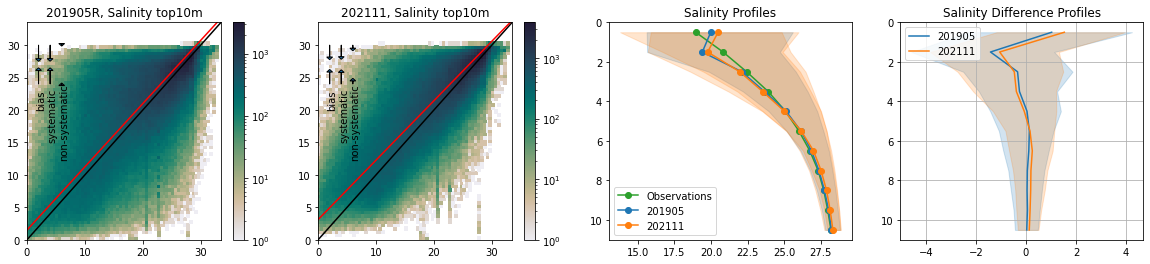

In [192]:
idepth = 0
jdepth = 10
itemp1, itemp2 = stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], 
               [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, Fraser_plume, 'Fraser_plume', 'top10m')

20.530088581653555
18.784438379512093


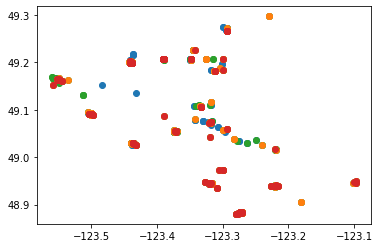

In [93]:
fig, ax = plt.subplots(1, 1)
plot_map(temp1, temp2, ax, Fraser_plume, 'Fraser_plume', idepth=0, jdepth=1)

        Unnamed: 0                 time (UTC)        Lat         Lon  \
0                0  2013-01-01 00:00:00+00:00  49.095300 -123.424400   
1                1  2013-01-01 00:01:00+00:00  49.096717 -123.427833   
2                2  2013-01-01 00:02:00+00:00  49.099150 -123.434067   
3                3  2013-01-01 00:03:00+00:00  49.101383 -123.440433   
4                4  2013-01-01 00:04:00+00:00  49.103583 -123.446800   
...            ...                        ...        ...         ...   
173446      173446  2013-12-14 08:33:00+00:00  49.001667 -123.154000   
173447      173447  2013-12-14 08:34:00+00:00  49.001167 -123.146600   
173448      173448  2013-12-14 08:35:00+00:00  49.001333 -123.141333   
173449      173449  2013-12-14 08:36:00+00:00  49.002460 -123.137920   
173450      173450  2013-12-14 08:37:00+00:00  49.004000 -123.134700   

        chlorophyll (ug/l)  temperature (degrees_Celcius)  salinity (g/kg)  \
0                 1.212017                       5.959450

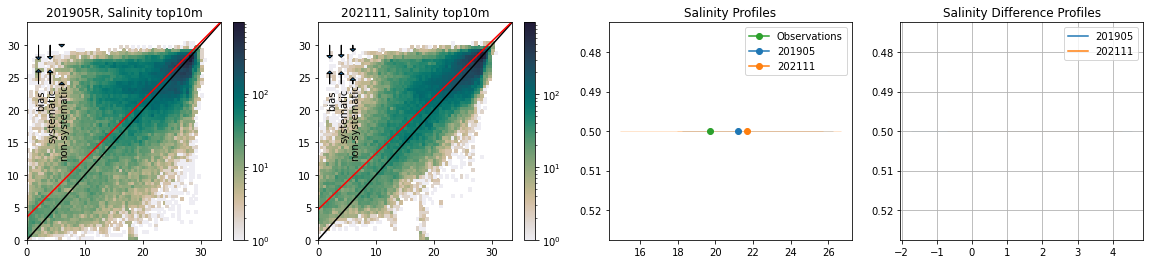

In [106]:
idepth = 0
jdepth = 10
temp1, temp2 = stats_and_plot(
                #[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], 
               [], [], [],
               #[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [], 
               [2013], # 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, Fraser_plume, 'Fraser_plume', 'top10m')

19.678017824263275
nan


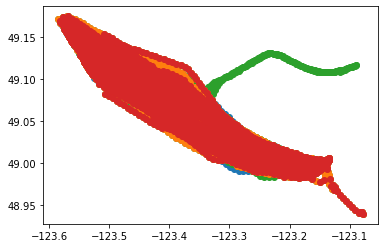

In [110]:
fig, ax = plt.subplots(1, 1)
plot_map(temp1, temp2, ax, Fraser_plume, 'Fraser_plume', idepth=0, jdepth=1)

19.678017824263275
23.033682343216263


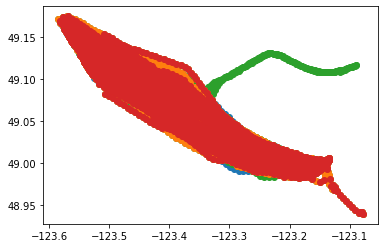

In [113]:
fig, ax = plt.subplots(1, 1)
plot_map(temp1, temp2, ax, Fraser_plume, 'Fraser_plume', idepth=0, jdepth=1)

22.123107899430376 173451
23.328867379105635 173451
26.053817344543205
25.076854126377143


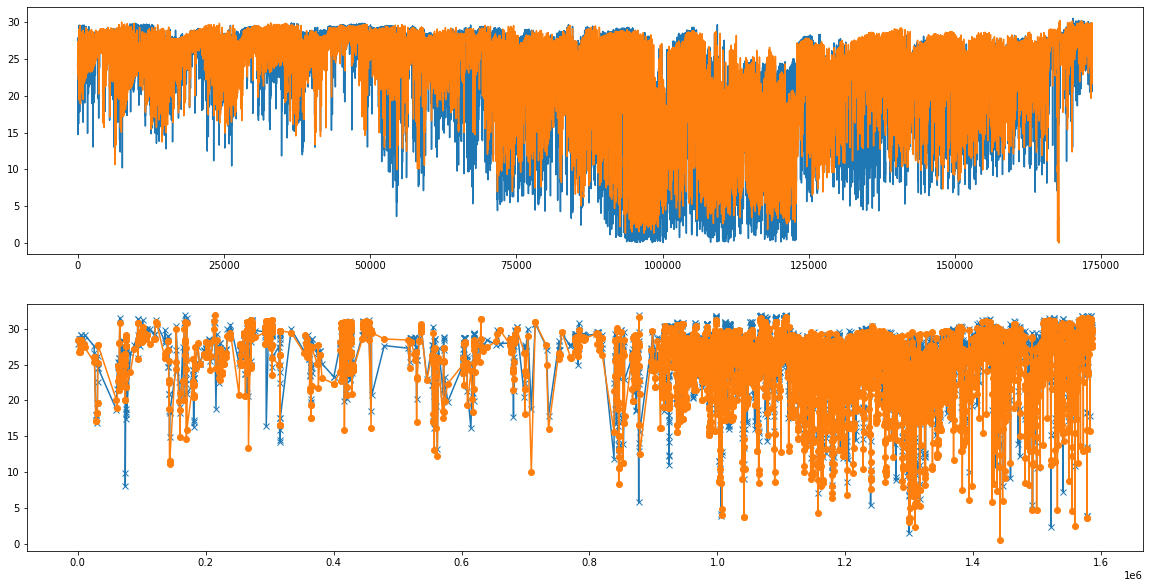

In [190]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
nf = 10000000
temp2[obsn][:nf].plot(ax=ax[0])
print (temp2[obsn][:nf].mean(), temp2[obsn][:nf].count())
print (temp2[modn][:nf].mean(), temp2[modn][:nf].count())
temp2[modn][:nf].plot(ax=ax[0])
ni = 1000000
itemp2[(itemp2.k < 1) & (itemp2[modn] < 1000)][obsn][:ni].plot(ax=ax[1], marker='x')
itemp2[(itemp2.k < 1) & (itemp2[modn] < 1000)][modn][:ni].plot(ax=ax[1], marker='o');
print (itemp2[(itemp2.k < 1) & (itemp2[modn] < 1000)][obsn][:ni].mean())
print (itemp2[(itemp2.k < 1) & (itemp2[modn] < 1000)][modn][:ni].mean())

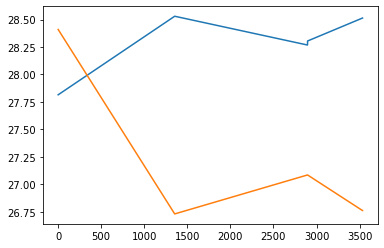

In [177]:
iwant = itemp2[itemp2.k < 1][:20]
plt.plot(iwant[iwant.mod_vosaline < 30]['SA'])
plt.plot(iwant['mod_vosaline'])

In [179]:
iwant[iwant.mod_vosaline < 1000][['SA', 'mod_vosaline']]

,SA,mod_vosaline
0,27.814801,28.409424
1353,28.529872,26.730228
2895,28.267852,27.084835
2896,28.304597,27.084835
3533,28.513321,26.761148
3534,28.513516,26.761148


<ipython-input-161-36e267e9912a>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(bathy['nav_lon'], bathy['nav_lat'], bathy['Bathymetry'], cmap=mycmap, vmax=15)


(50.45, 50.5)

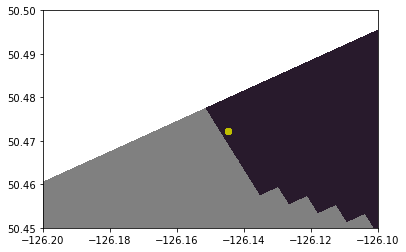

In [161]:
plt.pcolormesh(bathy['nav_lon'], bathy['nav_lat'], bathy['Bathymetry'], cmap=mycmap, vmax=15)
plt.plot(itemp2[itemp2.k < 1][6:15].Lon, itemp2[itemp2.k < 1][6:15].Lat, 'yo');
plt.xlim(-126.2, -126.1)
plt.ylim (50.45, 50.5)

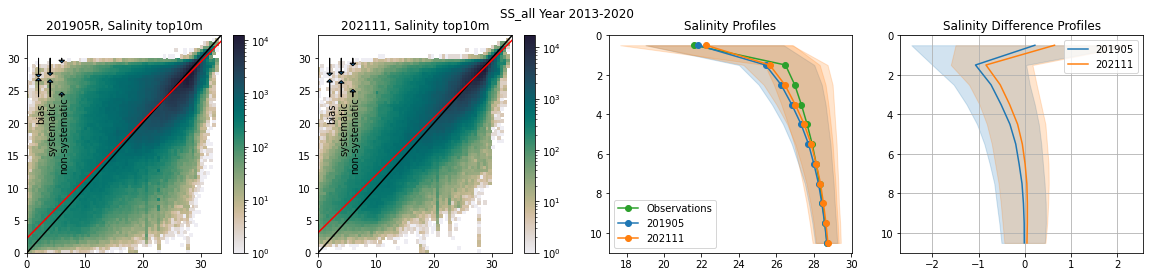

In [52]:
idepth = 0
jdepth = 10
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, SS_all, 'SS_all', 'top10m')

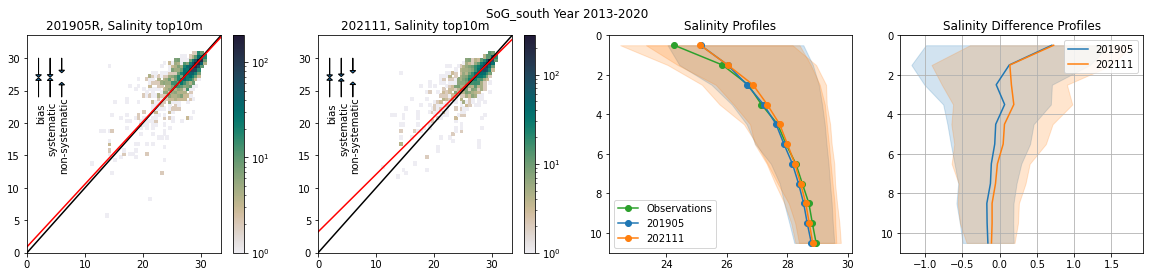

In [55]:
idepth = 0
jdepth = 10
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [],
               idepth, jdepth, SoG_south, 'SoG_south', 'top10m')

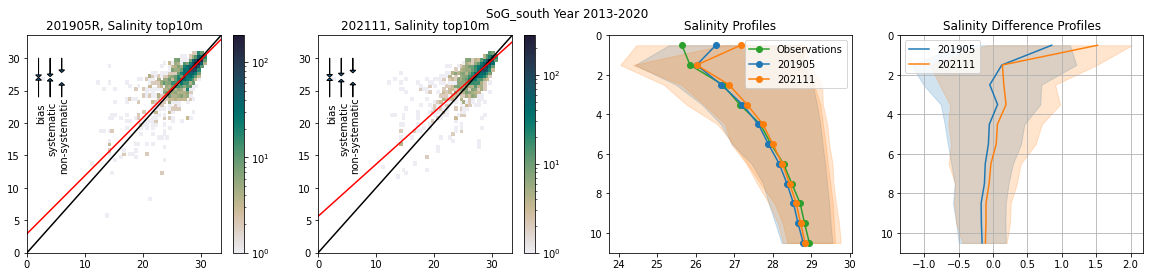

In [54]:
idepth = 0
jdepth = 10
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, SoG_south, 'SoG_south', 'top10m')

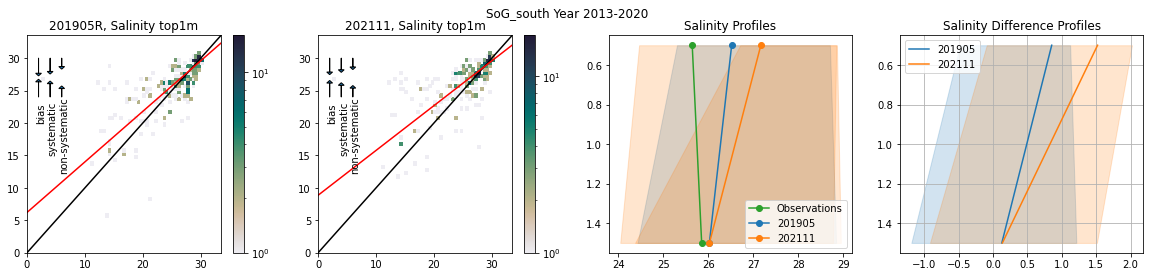

In [56]:
idepth = 0
jdepth = 1
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               idepth, jdepth, SoG_south, 'SoG_south', 'top1m')

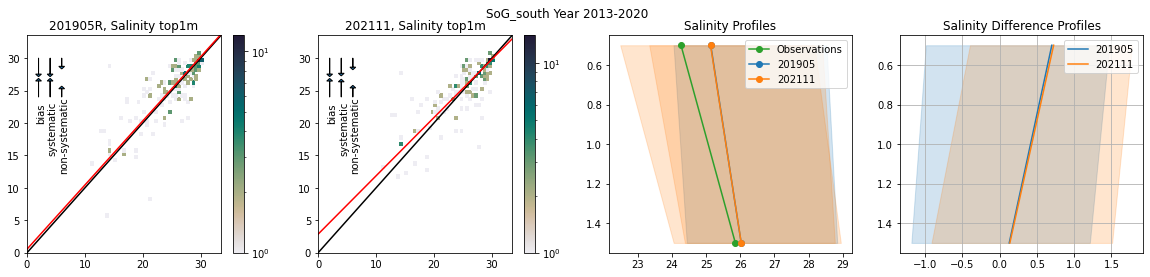

In [57]:
idepth = 0
jdepth = 1
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [],
               idepth, jdepth, SoG_south, 'SoG_south', 'top1m')

## Above 5 m

In [50]:
idepth = 0
jdepth = 5

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], 
                           idepth, jdepth, 'top5m')
for boxname in boxnames:
    if results[results.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results[results.region == boxname].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

SS_all


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1553504,0.179,4.88,4.88,0.162,0.0976,2.31,0.665,4.62,0.135
202111,1553464,0.597,4.01,3.97,0.109,0.116,3.12,0.966,3.69,0.179


SoG_south


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1581,0.103,2.13,2.13,0.134,0.114,3.17,0.379,1.99,0.168
202111,1581,0.296,2.15,2.13,0.148,0.215,6.11,0.752,1.83,0.307


SoG_center


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,724019,-0.656,3.7,3.64,0.206,0.0851,1.43,0.756,3.48,0.108
202111,724024,-0.36,3.21,3.19,0.141,-0.0115,-0.643,0.364,3.21,-0.0172


SoG_north


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,10129,-0.26,1.38,1.36,0.15,-0.485,-13.4,0.806,1.51,-0.858
202111,10129,0.0956,1.19,1.19,0.127,-0.29,-7.74,0.465,1.3,-0.494


PS_main


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1975,-0.867,1.58,1.32,0.304,-0.137,-4.79,0.888,1.41,-0.162
202111,1975,-1.17,1.77,1.33,0.231,-0.728,-22.1,1.55,1.4,-1.48


Haro_Boundary


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1105,-0.541,0.934,0.761,0.196,-0.18,-5.93,0.569,0.816,-0.28
202111,1105,-0.514,0.846,0.672,0.161,-0.16,-5.33,0.538,0.712,-0.27


JdF_west


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,778,-0.218,0.928,0.902,0.341,0.544,16.7,0.61,0.588,0.586
202111,778,-0.235,0.838,0.805,0.256,0.444,13.6,0.522,0.559,0.541


JdF_east


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2934,-0.343,0.635,0.535,0.283,-0.294,-9.41,0.381,0.601,-0.384
202111,2934,-0.388,0.567,0.414,0.205,-0.244,-7.93,0.411,0.448,-0.411


## Below 5 m

In [51]:
idepth = 5
jdepth = 39

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
               [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                           idepth, jdepth, 'below5m')
for boxname in boxnames:
    if results[results.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results[results.region == boxname].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

SS_all


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2088866,0.0772,0.371,0.363,0.0335,0.00965,0.371,0.0778,0.361,0.018
202111,2088880,0.0348,0.34,0.338,0.0286,0.0304,0.96,0.0469,0.331,0.0567


SoG_south


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,45459,0.0917,0.383,0.372,0.0534,-0.0511,-1.45,0.101,0.379,-0.0943
202111,45459,0.0568,0.355,0.351,0.0472,-0.019,-0.518,0.059,0.354,-0.0349


SoG_center


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,330495,0.143,0.315,0.28,0.0304,0.0266,0.954,0.145,0.276,0.0501
202111,330495,0.0833,0.272,0.259,0.0237,0.0675,2.14,0.104,0.244,0.126


SoG_north


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,212185,0.205,0.352,0.286,0.0466,0.11,3.47,0.226,0.257,0.197
202111,212192,0.158,0.327,0.287,0.0416,0.137,4.25,0.198,0.245,0.244


PS_main


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,47227,0.14,0.455,0.433,0.129,0.178,5.44,0.188,0.382,0.267
202111,47227,0.204,0.413,0.359,0.0898,0.0298,1.09,0.205,0.353,0.0511


Haro_Boundary


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,41521,-0.0543,0.351,0.347,0.0449,-0.0411,-1.34,0.0641,0.353,-0.0765
202111,41521,-0.0797,0.328,0.318,0.0389,-0.0346,-1.17,0.0847,0.322,-0.0653


JdF_west


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,24686,-0.0839,0.39,0.381,0.0347,-0.0192,-0.713,0.0863,0.384,-0.0362
202111,24686,-0.0862,0.372,0.362,0.0313,-0.0237,-0.865,0.0898,0.365,-0.0452


JdF_east


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,63078,-0.0776,0.393,0.385,0.0502,0.0163,0.441,0.0789,0.382,0.0294
202111,63078,-0.0981,0.363,0.349,0.0414,-0.00757,-0.339,0.0983,0.35,-0.0141
